In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from freegsnke import build_machine
from freegsnke.jtor_update import ConstrainPaxisIp
from freegsnke import GSstaticsolver
from freegsnke import equilibrium_update

In [7]:
tokamak = build_machine.tokamak(
    active_coils_path=f"C:/Users/LENOVO/Desktop/Datos tesis/freegsnke/machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"C:/Users/LENOVO/Desktop/Datos tesis/freegsnke/machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"C:/Users/LENOVO/Desktop/Datos tesis/freegsnke/machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"C:/Users/LENOVO/Desktop/Datos tesis/freegsnke/machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

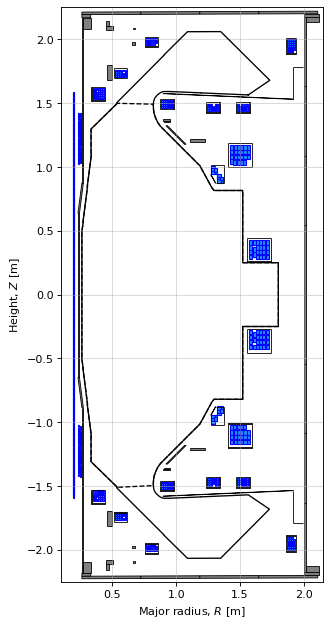

In [8]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

In [9]:
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

In [10]:
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

In [11]:
GSStaticSolver = GSstaticsolver.NKGSsolver(eq) 

In [12]:
Rx = 0.6      # X-point radius
Zx = 1.1      # X-point height
Ra = .85
Rout = 1.4    # outboard midplane radius
Rin = 0.34    # inboard midplane radius

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx, Rx], [Zx, -Zx]]

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, Rx, Rin, Rout, 1.3, 1.3, .8,.8], [Zx, -Zx, 0.,0., 2.1, -2.1,1.62,-1.62]]])
           
# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

In [13]:
eq.tokamak.set_coil_current('Solenoid', 5000)
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

In [14]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-12]*10+[1e-6]), 
                     )

-----
Inverse static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 1.02e+00
-----
Iteration: 0
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['-5.76e+01', '2.98e+04', '1.11e+04', '1.30e+04', '-7.91e+03', '2.73e+04', '-1.35e+04', '-6.50e+03', '-3.55e+04', '4.80e+03', '-3.67e-10']
Constraint losses = 7.38e-01
Relative update of tokamak psi (in plasma core): 2.53e+01
Handing off to forward solve (with updated currents).
Relative error =  9.31e-01
-----
Iteration: 1
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['2.01e+03', '-7.50e+03', '-2.81e+03', '-3.41e+03', '2.30e+03', '-7.39e+03', '3.88e+03', '1.88e+03', '9.76e+03', '-2.45e+03', '-2.06e-10']
Constraint losses = 1.70e-01
Relative update of tokamak psi (in plasma core): 2.62e-02
Handing off to forwar

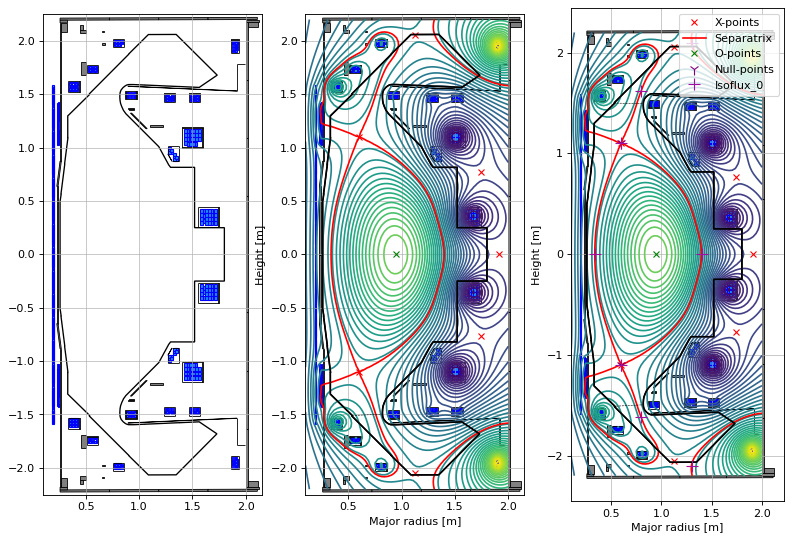

<Figure size 640x480 with 0 Axes>

In [15]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(zorder=0, alpha=0.75)
ax2.set_aspect('equal')
eq.tokamak.plot(axis=ax2,show=False)                                                          # plots the active coils and passive structures
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax2,show=False)                                                                  # plots the equilibrium
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)


ax3.grid(zorder=0, alpha=0.75)
ax3.set_aspect('equal')
eq.tokamak.plot(axis=ax3,show=False)                                                          # plots the active coils and passive structures
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax3,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax3, show=True)                             
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

In [16]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)


In [17]:
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as g:
    data=pickle.load(g)
print(type(data))
print(list(data.keys()))

<class 'dict'>
['Solenoid', 'PX', 'D1', 'D2', 'D3', 'Dp', 'D5', 'D6', 'D7', 'P4', 'P5', 'P6', 'vessel_1', 'vessel_2', 'vessel_3', 'vessel_4', 'vessel_5', 'vessel_6', 'vessel_7', 'vessel_8', 'vessel_9', 'vessel_10', 'vessel_11', 'vessel_12', 'vessel_13', 'vessel_14', 'vessel_15', 'vessel_16', 'vessel_17', 'vessel_18', 'vessel_19', 'vessel_20', 'vessel_21', 'vessel_22', 'centrecolumn_1', 'centrecolumn_2', 'centrecolumn_3', 'centrecolumn_4', 'centrecolumn_5', 'centrecolumn_6', 'centrecolumn_7', 'centrecolumn_8', 'centrecolumn_9', 'centrecolumn_10', 'colosseum_upper_1', 'colosseum_upper_2', 'colosseum_upper_3', 'colosseum_lower_1', 'colosseum_lower_2', 'colosseum_lower_3', 'colosseum_outer_upper_1', 'colosseum_outer_upper_2', 'colosseum_outer_lower_1', 'colosseum_outer_lower_2', 'ring_plate_minor_upper_1', 'ring_plate_minor_upper_2', 'ring_plate_minor_lower_1', 'ring_plate_minor_lower_2', 'ring_plate_major_upper_1', 'ring_plate_major_lower_1', 'psp_upper_1', 'psp_lower_1', 'gas_baffle_uppe

In [18]:
for key in data:
    print(f"\n🔹 Llave: {key}")
    print(f"📦 Valor asociado: {data[key]}")


🔹 Llave: Solenoid
📦 Valor asociado: 5000.0

🔹 Llave: PX
📦 Valor asociado: 4613.049761958626

🔹 Llave: D1
📦 Valor asociado: 6051.841804928801

🔹 Llave: D2
📦 Valor asociado: 1894.9173317832135

🔹 Llave: D3
📦 Valor asociado: 1663.7594766897298

🔹 Llave: Dp
📦 Valor asociado: -397.8437425044009

🔹 Llave: D5
📦 Valor asociado: 3586.7284054932893

🔹 Llave: D6
📦 Valor asociado: -1083.6789526602354

🔹 Llave: D7
📦 Valor asociado: -562.9300303560887

🔹 Llave: P4
📦 Valor asociado: -4564.190198138347

🔹 Llave: P5
📦 Valor asociado: -4048.662255491955

🔹 Llave: P6
📦 Valor asociado: 0.0004911931468066169

🔹 Llave: vessel_1
📦 Valor asociado: 0.0

🔹 Llave: vessel_2
📦 Valor asociado: 0.0

🔹 Llave: vessel_3
📦 Valor asociado: 0.0

🔹 Llave: vessel_4
📦 Valor asociado: 0.0

🔹 Llave: vessel_5
📦 Valor asociado: 0.0

🔹 Llave: vessel_6
📦 Valor asociado: 0.0

🔹 Llave: vessel_7
📦 Valor asociado: 0.0

🔹 Llave: vessel_8
📦 Valor asociado: 0.0

🔹 Llave: vessel_9
📦 Valor asociado: 0.0

🔹 Llave: vessel_10
📦 Valor asociad

In [19]:
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

# modify the total plasma current
profiles.Ip = 4e5

# modify the pressure on the magnetic axis
profiles.paxis = 6e3

# first we specify some alternative constraints
Rout = 1.4   # outboard midplane radius
Rin = 0.24   # inboard midplane radius

# locations of X-points
Rx = 0.45
Zx = 1.18
null_points = [[Rx, Rx], [Zx, -Zx]]

# isoflux constraints
isoflux_set = [[Rx, Rx, Rout, Rin, Rin, Rin, Rin, Rin, .75, .75, .85, .85, 1.3, 1.3],
           [Zx, -Zx,  0,  0,  .1, -.1, .2, -.2, 1.6, -1.6, 1.7, -1.7, 2.1, -2.1]]

# let's assume we're also seeking an equilibrium with no solenoid current
eq.tokamak.set_coil_current('Solenoid', 0)
eq.tokamak['Solenoid'].control = False # fixes the current

# pass the magnetic constraints to a new constrain object
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

# carry out the solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-9]*10+[1e-5]), 
                     )

-----
Inverse static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 9.72e-01
-----
Iteration: 0
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['7.05e+03', '7.90e+02', '2.84e+04', '3.23e+04', '-1.77e+04', '2.89e+04', '-2.57e+04', '-1.30e+04', '-4.43e+04', '1.54e+04', '-4.91e-05']
Constraint losses = 8.86e-01
Relative update of tokamak psi (in plasma core): 1.58e+00
Handing off to forward solve (with updated currents).
Relative error =  9.53e-01
-----
Iteration: 1
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['-2.89e+03', '-1.94e+03', '-8.93e+03', '-1.01e+04', '5.62e+03', '-9.48e+03', '7.97e+03', '3.99e+03', '1.42e+04', '-3.89e+03', '-4.51e-05']
Constraint losses = 3.03e-01
Relative update of tokamak psi (in plasma core): 2.14e-02
Handing off to forwar

In [20]:
# save the currents for later use
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
with open('simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

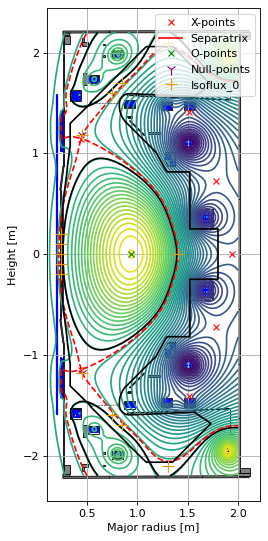

<Figure size 640x480 with 0 Axes>

In [21]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=True)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()